# SPECnet v1.0

## Input parameters
Press SHIFT-ENTER in the cell below to set simulation parameters.

In [ ]:
N = 30                         # number of agents
num_iter = 50                  # number of iterations the simulation runs
openness = 0                   # 0 <= openness <= 1   (0: always choose from neighbor, 1: always choose from entire city)
max_starting_wealth = 100      # each agent starts with wealth U~(0,max_starting_wealth)
salary_range = 10              # each iteration, each agent receives/loses U~(-salary_range, salary_range) wealth
proto_threshold = 50           # each agent in an encounter must have wealth about proto_threshold to form a proto
make_anim = true               # do, or do not, create an animation of results
animation_delay = 50           # milliseconds between animation frames
random_seed = 1234             # random number generator starting seed

params = [:N, :num_iter, :openness, :max_starting_wealth, :salary_range,
    :proto_threshold, :make_anim, :random_seed]
println("SPECnet simulation parameters:")
for param in params
    println("   $(param) = $(eval(param))")
end

## Simulation
Press SHIFT-ENTER in the cell below to run the simulation.

Running SPECnet...
   N = 30
   num_iter = 50
   openness = 0
   max_starting_wealth = 100
   salary_range = 10
   proto_threshold = 50
   make_anim = true
   random_seed = 1234
Iterations:
.........10
.........20
.........30
.........40
.........50
Building animation...


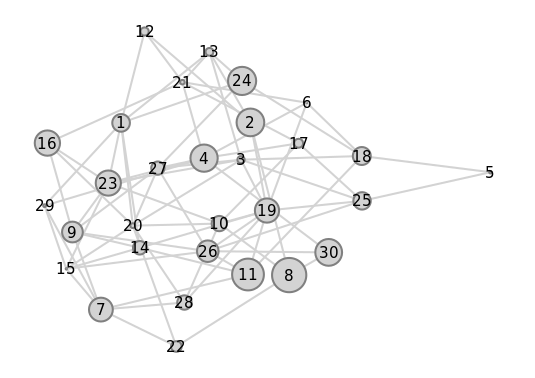

In [4]:
using Gadfly
using LightGraphs
using GraphPlot, Compose
using ColorSchemes, Colors
using Misc
using Random 
using Cairo, Fontconfig

Random.seed!(random_seed)

# Note on representation:
#
# The word "agent" refers to an integer in the range 1:N (where N = N_0 is the
# original number of agents). An agent's number *always stays the same*, even
# when agents die whose number is lower than its number.
#
# The word "node," on the other hand, refers to an integer in the range 1:N_t,
# which is the current number of living agents at time t. The node numbers will
# always occupy the entire contiguous sequence 1:N_t (with no "holes").
#
# Example: suppose N_0 is 5, so there are 5 agents initially. At the start of
# the sim, the agents are 1, 2, 3, 4, 5, and the nodes are 1, 2, 3, 4, 5. If
# agents #2 and #4 die, then the living agents would be 1, 3, 5, and the nodes
# would be 1, 2, 3.
#
# The functions "get_node_for_agent()" and "get_agent_for_node()" translate
# between the two. In the above example, calling get_node_for_agent(5) would
# return the value 3, and get_agent_for_node(3) would return 5. Calling
# get_node_for_agent(2) would return the Julia constant "Nothing". Calling
# get_agent_for_node(5) would also return "Nothing".

################################ functions ################################

# Return the node id in the current graph that matches the agent whose number
# is passed. If the agent is dead, return Nothing.
function get_node_for_agent(agent)
    global agents_to_nodes
    ret_val = agents_to_nodes[agent]
    return ret_val != 0 ? ret_val : Nothing
end

# Return the agent number represented in the graph by the node id passed. If
# the parameter is greater than the number of living agents, return Nothing.
function get_agent_for_node(node)
    global agents_to_nodes
    if !(node in values(agents_to_nodes))
        return Nothing
    end
    nodes_to_agents = rev_dict(agents_to_nodes)
    return nodes_to_agents[node]
end

# Mark the agent "dead" whose agent number is passed. This involves surgically
# removing it from the graph, adding it to the "dead" list, adjusting the
# agent-to-node mappings, and deleting it from the list of last-frame's plot
# coordinates.
function kill_agent(dying_agent)
    global graph, dead, agents_to_nodes, locs_x, locs_y
    dying_node = get_node_for_agent(dying_agent)
    deleteat!(locs_x, dying_node)
    deleteat!(locs_y, dying_node)

    friend_nodes = collect(neighbors(graph, dying_node))
    for friend_node in friend_nodes
        rem_edge!(graph, dying_node, friend_node)
    end
    push!(dead, dying_agent)
    agents_to_nodes = Dict(a=>
        (a==dying_agent ? Nothing :
            (a<dying_agent ? n : n-1))
        for (a,n) in agents_to_nodes)
    pop!(agents_to_nodes,dying_agent)
    rem_vertex!(graph, dying_node)

end

# Return true if the agent is a member of any proto institution.
in_proto(agent) = any(agent in proto for proto in protos)

# Return true if the agent is a rich enough to joing a proto, and available to
# do so.
function eligible_for_proto(agent)
    return wealths[agent] > proto_threshold && !in_proto(agent)
end

# Form a new proto between two agents.
function form_proto(agent1, agent2)
    global protos
    push!(protos, Set{Int64}([agent1,agent2]))
end

function assert_no_dead_neighbors(graph, agent, dead)
    node = agents_to_nodes[agent]
    if intersect(
        Set(map(node->get_agent_for_node(node),neighbors(graph, node))),
            dead) != Set()
        nodes_to_agents = rev_dict(agents_to_nodes)
        error("Dead neighbor of $(agent)!\n" *
            "neighbors: $(nodes_to_agents[neighbors(graph, node)]) "*
            "dead: $(dead)")
    end
end

function compute_colors()
    global protos, possible_colors, N
    [ in_proto(get_agent_for_node(node)) ?
        possible_colors[
            findfirst(x -> get_agent_for_node(node) in x, protos)] :
            (get_agent_for_node(node) in dead ?
                    colorant"pink" : colorant"lightgrey")
    for node in values(agents_to_nodes) ]
end

rev_dict(d) = Dict(y=>x for (x,y) in d)
###########################################################################


println("Running SPECnet...")
for param in params
    println("   $(param) = $(eval(param))")
end

# A list of proto-institutions, each of which is a set of participating agent
# numbers. (Could be a set instead of a list, but we're using it as an index to
# the colors array, to uniquely color members of each proto.)
protos = Set{Int64}[]

# The numbers of agents who have perished (initially none).
dead = Set{Int64}()

# The initial social network.
graph = LightGraphs.SimpleGraphs.erdos_renyi(N,.2)
while !is_connected(graph)
    global graph
    pri("Not connected; regenerating...")
    graph = LightGraphs.SimpleGraphs.erdos_renyi(N,.2)
end
agents_to_nodes = Dict(k=>k for k in 1:N)

# Agent attributes.
wealths = rand(Float16, N) * max_starting_wealth

possible_colors = Random.shuffle(ColorSchemes.rainbow.colors)


# (Erase old images.)
run(`rm -f $(tempdir())/output"*".png $(tempdir())/output"*".svg`)

locs_x, locs_y = nothing, nothing

println("Iterations:")

for iter in 1:num_iter

    if iter % 10 == 0 println(iter) else print(".") end

    global graph, locs_x, locs_y

    if locs_x == nothing
        locs_x, locs_y = spring_layout(graph)
    else
        locs_x, locs_y = spring_layout(graph, locs_x, locs_y)
    end

    agent1 = rand(keys(agents_to_nodes))
    assert_no_dead_neighbors(graph, agent1, dead)
    if rand(Float16) < openness  ||
            length(neighbors(graph, agents_to_nodes[agent1])) == 0
        # Choose from the graph at large.
        agent2 = rand(filter(x->x!=agent1,keys(agents_to_nodes)))
        prd("$(agent1) encounters at-large $(agent1)")
    else
        # Choose from a neighbor.
        node2 = rand(neighbors(graph,agents_to_nodes[agent1]))
        nodes_to_agents = rev_dict(agents_to_nodes)
        agent2 = nodes_to_agents[node2]
        prd("$(agent1) encounters neighbor $(agent2)")
    end
    assert_no_dead_neighbors(graph, agent2, dead)

    if eligible_for_proto(agent1) && eligible_for_proto(agent2)
        form_proto(agent1, agent2)
        # Since they're forming a proto, they also become socially connected
        # (if they weren't already.)
        if !has_edge(graph, agents_to_nodes[agent1], agents_to_nodes[agent2])
            add_edge!(graph, agents_to_nodes[agent1], agents_to_nodes[agent1])
        end
    end

    colors = compute_colors()

    remember_layout = x -> spring_layout(x, locs_x, locs_y)

    labels_to_plot = map(node->get_agent_for_node(node),
        1:length(agents_to_nodes))
    wealths_to_plot = map(node->wealths[get_agent_for_node(node)],
        1:length(agents_to_nodes))
    plot = gplot(graph,
        layout=remember_layout,
        nodelabel=labels_to_plot,
        NODESIZE=.08,
        nodesize=ifelse.(wealths_to_plot .> 0, 
                         wealths_to_plot*4,
                         maximum(wealths_to_plot)*2),
        nodestrokec=colorant"grey",
        nodestrokelw=.5,
        nodefillc=colors)
    draw(PNG("$(tempdir())/output$(lpad(string(iter),3,'0')).png"), plot)

    # Payday!
    wealths .+= (rand(Float16, N) .- .5) .* salary_range
    for d in dead
        wealths[d] = -500
    end
    proto_payoffs = [ in_proto(agent) ? rand(Float16)*10 : 0
        for agent in 1:N ]
    wealths .+= proto_payoffs

    dying_agents = setdiff((1:N)[wealths .< 0], dead)
    for dying_agent in dying_agents
        prd("Agent $(dying_agent) died!")
        kill_agent(dying_agent)
    end
end

if make_anim
    println("Building animation...")
    run(`mogrify -format svg $(tempdir())/output"*".png`)
    run(`convert -delay $(animation_delay) $(tempdir())/output"*".svg $(tempdir())/output.gif`)
end
                                    
display("image/gif", read("$(tempdir())/output.gif"))